In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ['LD_LIBRARY_PATH']= '$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# helper function for data visualization
def visualize(show=True, write=False, path=None, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if show:
        plt.show()
    if write:
        plt.savefig(path)
    if not show and write:
        plt.close()

In [3]:
n_cpu = os.cpu_count()
print('CPUs: ', n_cpu)

CPUs:  72


In [4]:
def memory_usage():
    """Memory usage of the current process in GB."""
    status = None
    result = {'peak': 0, 'rss': 0}
    try:
        # This will only work on systems with a /proc file system
        # (like Linux).
        status = open('/proc/self/status')
        for line in status:
            parts = line.split()
            key = parts[0][2:-1].lower()
            if key in result:
                result[key] = int(parts[1])*0.000001
    finally:
        if status is not None:
            status.close()
    return result

In [5]:
memory_usage()

{'peak': 1.304756, 'rss': 0.12970399999999999}

### Prep lists of input files

In [6]:
from glob import glob
import re
import pandas as pd
from random import sample

In [7]:
# set working directory
os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set suffixes to define imagery to be used
suffix_list = ['rgb', 'tpi']

# set directories for training data and labels
DATA_FOLDER = './cnn_train_images/{}_{}.tif'
LABEL_FOLDER = './cnn_train_labels/{}_labels.tif'

In [8]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [9]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[-3:]) for y in all_ids]))

In [10]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.3)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [11]:
#df_tiles

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io

In [13]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dem': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='uint8')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        else:
            image = image.transpose(2, 0, 1).astype('float32')
            mask = mask.transpose(2, 0, 1).astype('float32')
        return image, mask
        
    def __len__(self):
        return len(self.ids)




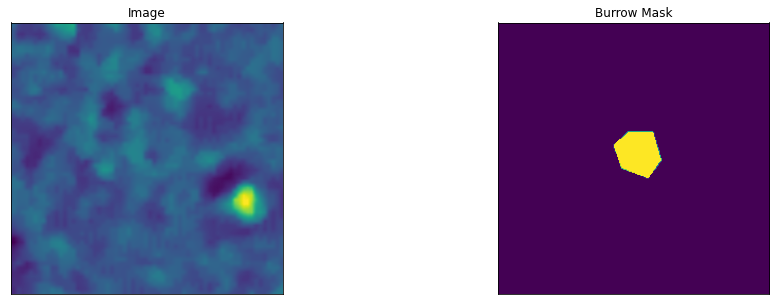

In [14]:
# Look at a training image with a burrow

dataset = Dataset(train_ids, 
                  suffix_list,
                  DATA_FOLDER,
                  LABEL_FOLDER,
                  classes=['burrow'])

image, mask = dataset[5] # get sample with known burrow
visualize(
    image=image.squeeze().transpose(1, 2, 0)[:, :, 3:],#.astype('uint8'), 
    burrow_mask=mask.squeeze(),
)

### Augmentations

In [15]:
import albumentations as albu

In [16]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.0, rotate_limit=45, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),

        #albu.GaussNoise(p=0.2, var_limit=1.0),
        #albu.Perspective(p=0.5),

        #albu.OneOf(
        #    [
        #        #albu.CLAHE(p=1), # required int8 images
        #        albu.RandomBrightnessContrast(p=1),
        #        #albu.RandomGamma(p=1),
        #        #albu.HueSaturationValue(p=1),
        #    ],
        #    p=0.9,
        #),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=(3, 7), p=1),
                albu.MotionBlur(blur_limit=(3, 7), p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

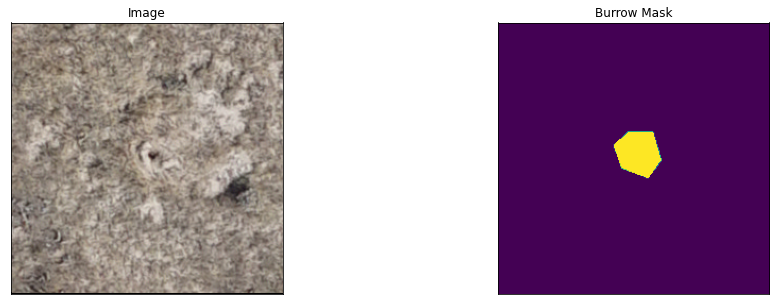

In [17]:
def simp_aug():
    train_transform = [
        #albu.Perspective(p=0.5),
        #albu.GaussNoise(p=1, var_limit=1.0),
        albu.RandomGamma(p=1),
    ]
    return albu.Compose(train_transform)

simp_aug_dataset = Dataset(
    train_ids,
    ['rgb'],
    DATA_FOLDER,
    LABEL_FOLDER,
    augmentation=simp_aug(),
    classes=['burrow'])

image, mask = simp_aug_dataset[5] # get sample with known burrow
visualize(
    image=image.squeeze().transpose(1, 2, 0).astype('uint8'), 
    burrow_mask=mask.squeeze(),
)

In [18]:
#valid_ids.index('poly_48_22W_random_8')

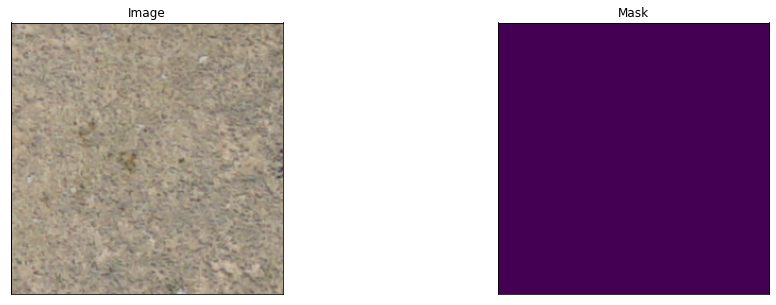

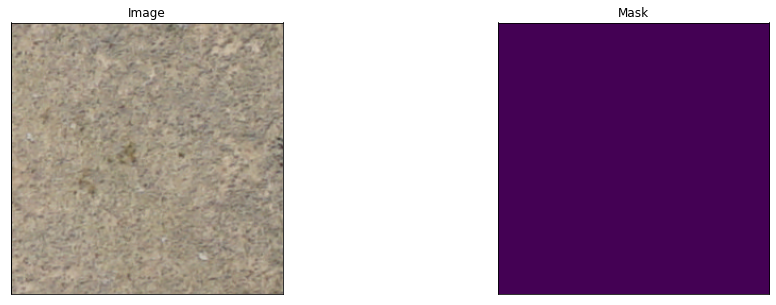

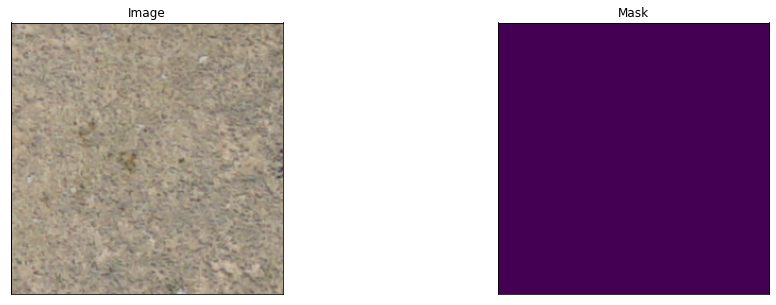

In [19]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    valid_ids,
    ['rgb'],
    DATA_FOLDER,
    LABEL_FOLDER,
    augmentation=get_training_augmentation(),
    classes=['burrow'])

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[68]
    visualize(image=image.squeeze().transpose(1, 2, 0).astype('uint8'),
              mask=mask.squeeze())

### Create and train model

In [20]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [21]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'# 'cpu'# 

In [22]:
train_dataset = Dataset(
    train_ids,
    suffix_list,
    DATA_FOLDER,
    LABEL_FOLDER,
    augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES)

valid_dataset = Dataset(
    valid_ids,
    suffix_list,
    DATA_FOLDER,
    LABEL_FOLDER,
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES)


train_loader = DataLoader(train_dataset, batch_size=12, shuffle=False,
                          drop_last=True, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

In [23]:
# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels=train_dataset[0][0].shape[0],
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [24]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5)
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [25]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [26]:
# train model for 5 epochs

max_score = 0
no_improve = 0

for i in range(0, 30):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './cnn_results/best_model_' + '_'.join(suffix_list) + '.pth')
        valid_logs['best_epoch'] = i + 1
        print('Model saved!')
        no_improve = 0
    else:
        no_improve += 1
        print('No improvement in ' + str(no_improve) + ' epochs. Model not saved.')
        
    if i == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    if no_improve == 5:
        print('...ending training')
        break


Epoch: 0
valid: 100%|██████████| 187/187 [00:05<00:00, 33.24it/s, dice_loss - 0.5181, iou_score - 0.5886, accuracy - 0.9553, precision - 0.7417, recall - 0.8149, fscore - 0.6646]
Model saved!

Epoch: 1
valid: 100%|██████████| 187/187 [00:05<00:00, 36.38it/s, dice_loss - 0.4418, iou_score - 0.5897, accuracy - 0.9553, precision - 0.7247, recall - 0.8423, fscore - 0.6689]
Model saved!

Epoch: 2
valid: 100%|██████████| 187/187 [00:06<00:00, 29.18it/s, dice_loss - 0.4561, iou_score - 0.6392, accuracy - 0.9694, precision - 0.8303, recall - 0.782, fscore - 0.7085] 
Model saved!

Epoch: 3
valid: 100%|██████████| 187/187 [00:06<00:00, 29.48it/s, dice_loss - 0.4275, iou_score - 0.659, accuracy - 0.9705, precision - 0.8436, recall - 0.7938, fscore - 0.7253] 
Model saved!

Epoch: 4
valid: 100%|██████████| 187/187 [00:05<00:00, 31.65it/s, dice_loss - 0.3618, iou_score - 0.6743, accuracy - 0.9697, precision - 0.8153, recall - 0.8279, fscore - 0.7447]
Model saved!

Epoch: 5
valid: 100%|██████████| 1

In [29]:
#valid_logs['best_epoch'] = 27
with open('./cnn_results/best_model_' + '_'.join(suffix_list) + '_validation.txt','w') as data: 
      data.write(str(valid_logs))

### Test best model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./cnn_results/best_model_' + '_'.join(suffix_list) + '.pth')

In [ ]:
# test dataset without transformations for image visualization
test_dataset = Dataset(
    test_ids,
    suffix_list,
    DATA_FOLDER,
    LABEL_FOLDER,
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
#next(iter(test_dataloader))[0]#.shape#.squeeze().transpose(0, 2).transpose(1, 2).shape

In [ ]:
best_model.eval()

with torch.no_grad():
    prediction = best_model.forward(next(iter(test_dataloader))[0].cuda())

In [ ]:
prediction

In [ ]:
test_metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5)
]

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=test_metrics,
    device=DEVICE,
    verbose=True,
)

logs = test_epoch.run(test_dataloader)

In [80]:
logs

NameError: name 'logs' is not defined

### Visualize predictions

In [ ]:
test_dataset_vis = Dataset(
    test_ids,
    suffix_list,
    DATA_FOLDER,
    LABEL_FOLDER,
    classes=CLASSES)

In [ ]:
if not os.path.exists('./cnn_results/test_predictions' + '_'.join(suffix_list)):
    os.mkdir('./cnn_results/test_predictions' + '_'.join(suffix_list))
for i in range(100):
    n = np.random.choice(len(test_dataset))
    #n = i
    get_vis = test_dataset_vis[n]
    image_vis = test_dataset_vis.image_dict['rgb'].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

    plt.savefig('./cnn_results/test_predictions/' + 'pred_' + test_dataset_vis.ids[n] + '.png')

In [ ]:
import itertools
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
import shapely.wkt as wkt

In [ ]:
df_polys['geometry'] = df_polys.geometry.apply(lambda x: Polygon(wkt.loads(x)))
gdf_polys = gpd.GeoDataFrame(df_polys, geometry='geometry')
gdf_polys = gdf_polys.set_crs(32613)

In [ ]:
for ID, gdf_polys_sub in gdf_polys.groupby('Tile'):
    if all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
        continue
    else:
        print(ID)
        # get the path base to the imagery associated with the training tile
        tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
        # get the x/y coordinates of the bounding box for the training polygon within the tile
        box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
        box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
        # get the box coordinate pairs
        ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
        # create a polygon from the coordinate pairs
        tile_geom = Polygon([ll, ul, ur, lr])
        # create the full path to the RGB image of the training tile
        rgb_path = tilePATH + 'rgb.tif'
        with rio.open(rgb_path) as src_rgb:   
            profile_rgb = src_rgb.meta
            rgb_out, transform_out = mask.mask(src_rgb,
                                               [tile_geom],
                                               crop=True)
            rgb_out = rgb_out.astype('int')
            #rgb_out = rgb_out[:, -win_size:, :win_size]
            #show(rgb_out)
            ll_i = src_rgb.index(*ll)
            ur_i = src_rgb.index(*ur)

            label = rasterize(gdf_polys_sub.geometry, 
                              out_shape=rgb_out.shape[1:], transform=transform_out,
                              default_value=1)
            #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
            profile_rgb.update({'dtype': 'int16',
                                'width': rgb_out.shape[0],
                                'height': rgb_out.shape[1],
                                'transform': transform_out})
            profile_single = profile_rgb.copy()
            profile_single.update({'count': 1})
            profile_single_float = profile_single.copy()
            profile_single_float.update({'dtype': 'float64'})
            #show(label)

        n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
        n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

        pr_mask = np.empty_like(rgb_out[0, :, :])
        for r in range(n_row_chunks):
            if (r + 1) * 256 > rgb_out.shape[1]:
                r_min = rgb_out.shape[1] - 256
                r_max = rgb_out.shape[1]
            else:
                r_min = r * 256
                r_max = (r + 1) * 256
            for c in range(n_col_chunks):
                if (c + 1) * 256 > rgb_out.shape[2]:
                    c_min = rgb_out.shape[2] - 256
                    c_max = rgb_out.shape[2]
                else:
                    c_min = c * 256
                    c_max = (c + 1) * 256
                rgb_sub = rgb_out[:, r_min:r_max, c_min:c_max]
                rgb_image_sub = preprocessing_fn(rgb_sub.transpose((1, 2, 0))).astype('float32').transpose((2, 0, 1))
                x_tensor = torch.from_numpy(rgb_image_sub).to(DEVICE).unsqueeze(0)
                pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().squeeze()

        visualize(show=False,
                  write=True,
                  path='./cnn_results/test_predictions/' + 'pred_' + ID + '.png',
                  image=rgb_out.transpose((1, 2, 0)), 
                  ground_truth_mask=label.squeeze(), 
                  predicted_mask=pr_mask.squeeze()
            )

In [ ]:
ID = 'CN_6'
gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
print(ID)
# get the path base to the imagery associated with the training tile
tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    rgb_out = rgb_out.astype('int')
    #rgb_out = rgb_out[:, -win_size:, :win_size]
    show(rgb_out)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)

    label = rasterize(gdf_polys_sub.geometry, 
                      out_shape=rgb_out.shape[1:], transform=transform_out,
                      default_value=1)
    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
    profile_rgb.update({'dtype': 'int16',
                        'width': rgb_out.shape[0],
                        'height': rgb_out.shape[1],
                        'transform': transform_out})
    profile_single = profile_rgb.copy()
    profile_single.update({'count': 1})
    profile_single_float = profile_single.copy()
    profile_single_float.update({'dtype': 'float64'})
    show(label)

n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

pr_mask = np.empty_like(rgb_out[0, :, :])
for r in range(n_row_chunks):
    if (r + 1) * 256 > rgb_out.shape[1]:
        r_min = rgb_out.shape[1] - 256
        r_max = rgb_out.shape[1]
    else:
        r_min = r * 256
        r_max = (r + 1) * 256
    for c in range(n_col_chunks):
        if (c + 1) * 256 > rgb_out.shape[2]:
            c_min = rgb_out.shape[2] - 256
            c_max = rgb_out.shape[2]
        else:
            c_min = c * 256
            c_max = (c + 1) * 256
        rgb_sub = rgb_out[:, r_min:r_max, c_min:c_max]
        rgb_image_sub = preprocessing_fn(rgb_sub.transpose((1, 2, 0))).astype('float32').transpose((2, 0, 1))
        x_tensor = torch.from_numpy(rgb_image_sub).to(DEVICE).unsqueeze(0)
        pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().squeeze()

visualize(
        image=rgb_out.transpose((1, 2, 0)), 
        ground_truth_mask=label.squeeze(), 
        predicted_mask=pr_mask.squeeze()
    )

In [ ]:
rgb_image_sub.shape